# Agents issus de la littérature

In [1]:
from atom import *
from data_processing import *
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stats
plt.rcParams['figure.figsize'] = (15,10)

In [2]:
class ZITTrader_v2(Trader):
    def __init__(self, market, initial_assets=None, cash=0):
        Trader.__init__(self, market, initial_assets, cash)
    def __str__(self):
        return "ZITv2 " + super().__str__()
    def decide_order(self, market, asset):
        # On compte le nombre d'ordres placés dans les orderbooks par cet agent...
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset2].asks.tree+market.orderbooks[asset2].bids.tree if o.source == self]) for asset2 in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK' and self.assets[asset] > 0: # Si on a quantité > 0 d'actions pour cet asset...
                # On ne vend pas une quantité d'actions > à celle qu'on a.
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, min(self.assets[asset], 9)))
            elif direction == 'BID' and self.cash >= 1000: # Pour acheter, il faut de l'argent...
                price = random.randint(1000, min(self.cash, 9999))
                # On n'achète pas pour un volume > au cash qu'on a.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, min(self.cash//price, 9)))
        return None # Dans tous les autres cas, on ne place pas d'ordre.
    
class ZITPeriodique(Trader):
    def __init__(self, market, initial_assets=None, cash=0, periode=1):
        Trader.__init__(self, market, initial_assets, cash)
        self.periode = periode
    def __str__(self):
        return "ZITdelta %i" % self.trader_id
    def decide_order(self, market, asset):
        
        if ((market.time+1)%self.periode==0):
            return LimitOrder(asset, self, random.choice(['ASK', 'BID']), random.randint(1000,9999), random.randint(1, 9))
        else:
            return None 

Ces agents se basent à l'origine sur un modèle client - trader : le client demande au trader de passer des ordres à un prix v et le trader essaye de maximiser son profit par rapport à ce prix et au marché.
Atom ne suit pas ce modèle et le prix v demandé par le client est donc simulé par une estimation de la valeur fondamentale du produit.

### ZIC : Zero-Intelligence Constrained Traders

Ces traders n'achètent qu'à des prix aléatoires supérieurs et ne vendent qu'à des prix aléatoires inférieurs à la valeur de v.

In [3]:

# v = hash table of redemption value i.e. dic des valeurs fondamentales perçues
class ZIC(Trader):
    def __init__(self, market, initial_assets=None, cash=0, v=5000):
        Trader.__init__(self, market, initial_assets, cash)
        self.v = v
    def __str__(self):
        return "ZIC " + super().__str__()
    def decide_order(self, market, asset):
        nb_placed_orders = len([o for o in market.orderbooks[asset].asks.tree+market.orderbooks[asset].bids.tree if o.source == self])
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK':
                return LimitOrder(asset, self, 'ASK', random.randint(self.v[asset], 9999), random.randint(1, 9))
            elif direction == 'BID':
                return LimitOrder(asset, self, 'BID', random.randint(1000, self.v[asset]), random.randint(1, 9))
        return None

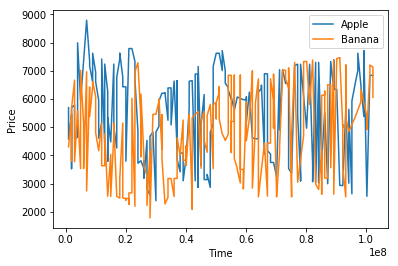

Wealth moyen ZIT : -11560.0
Wealth moyen ZIC : 11560.0


In [4]:
file = open('mytrace.dat', 'w')
#m = Market(['Apple', 'Google'], out=file, fix='S')
m = Market(['Apple','Banana'], out=file, fix='S')

ZITs = []
ZICs = []

for i in range(5):
    #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    #m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))
    
    t = ZIC(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)})
    ZICs.append(t)
    m.add_trader(t)
    
    t = ZITTrader(m)
    ZITs.append(t)
    m.add_trader(t)
    
for i in range(100):
    m.run_once()
file.close()

Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

ZIT_wealths = []
ZIC_wealths = []
for i in range(len(ZITs)):
    ZIT_wealths.append(ZITs[i].get_wealth(m))
    ZIC_wealths.append(ZICs[i].get_wealth(m))
print("Wealth moyen ZIT :",np.mean(ZIT_wealths))
print("Wealth moyen ZIC :",np.mean(ZIC_wealths))

### ZIP : Zero-Intelligence-Plus Traders

Ces traders optimisent leur marge de profit en fonction du dernier prix grâce à de l'apprentissage : si il est proche de v, la marge sera réduite (car un ordre proposé à un prix trop éloigné de v ne trouvera pas de preneur), sinon elle sera augmentée (car un ordre proposé à un prix trop proche de v empêche des profits potentiels). 

In [23]:
# v = redemption value i.e. valeur fondamentale perçue
class ZIPab(Trader):
    def __init__(self, market, initial_assets=None, cash=0, v=5000, momentum=0.5, beta=0.3):
        Trader.__init__(self, market, initial_assets, cash)
        self.v = v
        self.price = -1
        self.marginA = 0
        self.prev_changeA = 0
        self.marginB = 0
        self.prev_changeB = 0
        self.momentum = momentum # momentum [0 - 1] i.e. coeff of importance of past change
        self.beta = beta #  learning rate [0.1 - 0.5]
    def __str__(self):
        return "ZIPab " + super().__str__()
    def decide_order(self, market, asset):
        
        def update_margin(direction):
            P = market.prices_hist[asset]
            if len(P)>=1:
                q = P[-1]
                if self.price == -1:
                    self.price = q
                diff = q - self.price
                
                if (direction=='ASK'):
                    change = ((1.0-self.momentum)*(self.beta*diff)) + (self.momentum*self.prev_changeA) 
                    self.prev_changeA = change
                    new_marg = ((self.price + change)/self.v[asset]) - 1.0
                    self.marginA = new_marg
                else:
                    change = ((1.0-self.momentum)*(self.beta*diff)) + (self.momentum*self.prev_changeB)
                    self.prev_changeB = change
                    new_marg = ((self.price + change)/self.v[asset]) - 1.0
                    self.marginB = new_marg
        
        
        nb_placed_orders = len([o for o in market.orderbooks[asset].asks.tree+market.orderbooks[asset].bids.tree if o.source == self])
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            update_margin(direction)
            if direction=='ASK':
                #print('ASK - margin:',self.marginA)
                return LimitOrder(asset, self, direction, int(self.v[asset]*(1+self.marginA)), random.randint(1, 9))
            else:
                #print('BID - margin:',self.marginB)
                return LimitOrder(asset, self, direction, int(self.v[asset]*(1+self.marginB)), random.randint(1, 9)) 
        return None
    
    
class ZIP(Trader):
    def __init__(self, market, initial_assets=None, cash=0, v=5000, momentum=0.5, beta=0.3):
        Trader.__init__(self, market, initial_assets, cash)
        self.v = v
        self.price = -1
        self.margin = 0
        self.prev_change = 0
        self.margin
        self.prev_change
        self.momentum = momentum # momentum [0 - 1] i.e. coeff of importance of past change
        self.beta = beta #  learning rate [0.1 - 0.5]
    def __str__(self):
        return "ZIP " + super().__str__()
    def decide_order(self, market, asset):
        
        def update_margin():
            P = market.prices_hist[asset]
            if len(P)>=1:
                q = P[-1]
                if self.price == -1:
                    self.price = q
                diff = q - self.price
                change = ((1.0-self.momentum)*(self.beta*diff)) + (self.momentum*self.prev_change) 
                self.prev_change = change
                new_marg = ((self.price + change)/self.v[asset]) - 1.0
                self.margin = new_marg
        
        
        nb_placed_orders = len([o for o in market.orderbooks[asset].asks.tree+market.orderbooks[asset].bids.tree if o.source == self])
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            update_margin()
            return LimitOrder(asset, self, direction, int(self.v[asset]*(1+self.margin)), random.randint(1, 9))
        return None

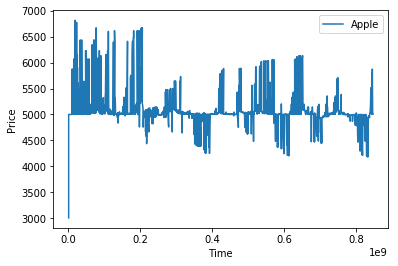

Wealth moyen ZIT : -4719.65
Wealth moyen ZIC : 465.6
Wealth moyen ZIP : 4254.05


In [30]:
file = open('mytrace.dat', 'w')
#m = Market(['Apple', 'Google'], out=file, fix='S')
m = Market(['Apple','Banana'], out=file, fix='S')
m = Market(['Apple'], out=file, fix='S')

ZITs = []
ZICs = []
ZIPs = []

for i in range(20):
    #m.add_trader(ZITTrader_delta(m, delta=0.05, pb_cancel=0.1))
    #m.add_trader(ZITPeriodique(m,periode=random.randint(1,5)))
    
    t = ZIC(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)})
    ZICs.append(t)
    m.add_trader(t)
    
    t = ZIP(m,v={'Apple':random.randint(3000,7000),'Banana':random.randint(3000,7000)},momentum=random.random(),beta=(random.random()*0.4)+0.1)
    ZIPs.append(t)
    m.add_trader(t)
    
    t = ZITTrader(m)
    ZITs.append(t)
    m.add_trader(t)
    
for i in range(100):
    m.run_once()
file.close()

Prices = extract_prices('mytrace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

ZIT_wealths = []
ZIC_wealths = []
ZIP_wealths = []

for i in range(len(ZITs)):
    ZIT_wealths.append(ZITs[i].get_wealth(m))
    ZIC_wealths.append(ZICs[i].get_wealth(m))
    ZIP_wealths.append(ZIPs[i].get_wealth(m))
print("Wealth moyen ZIT :",np.mean(ZIT_wealths))
print("Wealth moyen ZIC :",np.mean(ZIC_wealths))
print("Wealth moyen ZIP :",np.mean(ZIP_wealths))

### GDX
  
Besoin de l'historique des trades ?  
belief function = probability of offer with price p being taken  

AAG = accepted asks   - price >= p  
BG  = bids            - price >= p  
UAL = unaccepted asks - price <= p  

ABL = accepted bids   - price <= p  
AL  = asks            - price <= p  
UBG = unaccepted bids - price >= p  

fask(p) = (AAG + BG) / (AAG + BG + UAL)  
fbid(p) = (ABL + AL) / (ABL + AL + UBG)  

dans notre cas on a   

AAG = N(prices >= p)  (prices issus de l'historique)  
ABL = N(prices <= p)  (              "             )  


UAL = N(asks, prices <= p) (issus de l'order-book)  
UBG = N(bids, prices >= p) (          "          )  

BG = UBG + AAG  
AL = UAL + ABL  

In [49]:
P = m.prices_hist["Apple"]

def f_belief(market,asset,p,direction):
    P = market.prices_hist[asset]
    aag = 0
    abl = 0
    for price in P:
        if price>=p:
            aag+=1
        else:
            abl+=1
    book = market.orderbooks[asset]
    asks = book.asks.tree
    bids = book.bids.tree
    ual = 0
    for ask in asks:
        if ask.price <= p:
            ual+=1
    ubg = 0
    for bid in bids:
        if bid.price >= p:
            ubg+=1
    if direction=='ASK':
        return ((2*aag + ubg) / (2*aag + ubg + ual))
    else:
        return ((2*abl + ual) / (2*abl + ual + ubg))
    
print(f_belief(m,"Apple",6000,'ASK'))
print(f_belief(m,"Apple",4700,'BID'))
print(f_belief(m,"Apple",9000,'ASK'))
print(f_belief(m,"Apple",1000,'BID'))

0.5714285714285714
0.45454545454545453
0.0
0.0


In [ ]:
m.o